<a href="https://colab.research.google.com/github/rixwan-khan/Credit_Card_Fraud_Detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Credit Card Fraud Detection**

In this project, we focus on building a Credit Card Fraud Detection system using historical transaction data. The dataset labels each transaction as either:

Fraudulent (1) – Transactions identified as fraud.\
Normal (0) – Legitimate transactions.

\
**Objective:**
Develop a model that can accurately identify fraudulent transactions while minimizing false negatives, thereby enabling timely and reliable fraud detection.


### **0. Importing Libraries**

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [2]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools

# Machine Learning & Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm

# Gradient boosting & Advance models
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# imporitng library to handle imbalance data
from imblearn.over_sampling import SMOTE

# Evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve


##**1. Loading Dataset from Kaggle**

In [3]:
!pip install kaggle

# Upload kaggle.json from your Kaggle account
from google.colab import files
files.upload()   # upload kaggle.json

# Setup credentials
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)

# Download dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzip dataset
!unzip creditcardfraud.zip

# Load into pandas
import pandas as pd
df = pd.read_csv("creditcard.csv")



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.45GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **2. Data Exploration (EDA)**

In this section, exploring the dataset to understand its structure, and class imbalance. Visualizations and summary statistics will help identify patterns, outliers, and insights for building an effective fraud detection model.

###**2.1 Dataset Structure & Summary**

In [5]:
# Dimensions of dataset (Rows by columns)
df.shape

(284807, 31)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The dataset contains 284,807 transactions with 31 columns, including anonymized features, transaction amount, time, and a target class indicating fraud (1) or genuine (0).

### **2.2 Statistical Summary**

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The transaction amounts range from \$0 to \$25,691, with most transactions below \$100 (median \$22).

### **2.3 Missing Values**

In [8]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


### **2.4 Checking Duplicate:**

In [9]:
dup = df.duplicated().sum()
print('Duplicated rows:',dup)

Duplicated rows: 1081


#### ***2.4.1 Removing Duplicate Rows:***

In [10]:
df_copy = df.copy()
df = df.drop_duplicates()

### **2.5 Class Distribution (%)**

In [11]:
dist = df['Class'].value_counts(normalize=True)*100
dist

,proportion
Class,
0,99.83329
1,0.16671


#### **2.5.1 Transaction Amount based on Class**

In [12]:
# Transaction class:  0=Normal, 1=Fraud
non_fraud_txn = df[df['Class']==0]
fraud_txn = df[df['Class']==1]

In [13]:
# statistical summary for the Amount column of non-fraudulent transactions
non_fraud_txn.Amount.describe()

,Amount
count,283253.000000
mean,88.413575
std,250.379023
min,0.000000
25%,5.670000
50%,22.000000
75%,77.460000
max,25691.160000


In [14]:
# statistical summary for the Amount column of fraudulent transactions
fraud_txn.Amount.describe()

,Amount
count,473.000000
mean,123.871860
std,260.211041
min,0.000000
25%,1.000000
50%,9.820000
75%,105.890000
max,2125.870000


The dataset is highly imbalanced, with only a tiny fraction (0.17%) of transactions labeled as fraudulent and 99.8% are Normal.

By checking missing values it shows that there is no missing values in dataset.

## **3. Visualization**

### **3.1 Class Distribution**

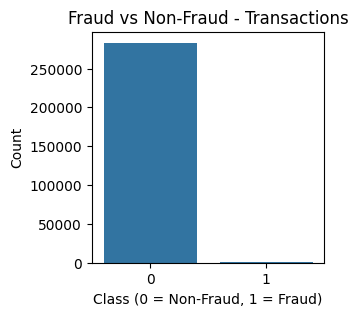

In [15]:
plt.figure(figsize=(3,3))

sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud - Transactions')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show();

Most transactions in the dataset are non-fraud, and only a few are fraudulent. This means normal models might find it hard to detect fraud, so we may need methods like oversampling, undersampling, or anomaly detection. The bar chart clearly shows this imbalance.

### **3.2 Outlier detection**

#### **3.2.1 Transaction amount comparision**

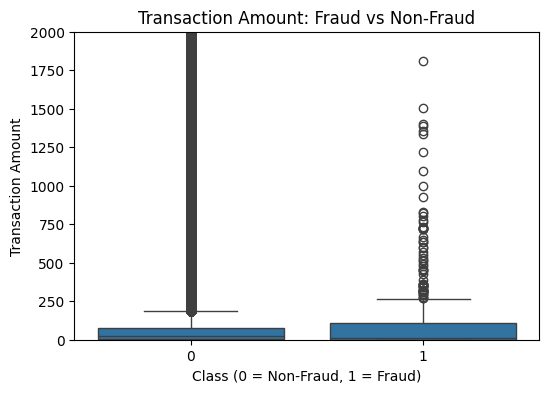

In [16]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x = 'Class',
    y = 'Amount',
    data = df
)
plt.title('Transaction Amount: Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.ylim(0, 2000)
plt.show()

- In Class 0 (non-fraud), most transactions are of small amounts, with a few reaching up to 2000, which are considered normal.

- In Class 1 (fraud), while many transactions are small, there are several extremely high-value transactions shown as circles, indicating outliers. This suggests that high transaction amounts can be useful for detecting fraud.

#### **3.2.2 Interquartile Range (IQR)**

In [17]:

# For Class 0 = Non-Fraud
non_fraud = df[df['Class'] == 0]['Amount']
Q1_0 = non_fraud.quantile(0.25) # 25th percentile
Q3_0 = non_fraud.quantile(0.75) # 75th percentile
IQR_0 = Q3_0 - Q1_0    # IQR range

# For Class 1 - Fraud
fraud = df[df['Class'] == 1]['Amount']
Q1_1 = fraud.quantile(0.25)    # 25th percentile
Q3_1 = fraud.quantile(0.75)    # 75th percentile
IQR_1 = Q3_1 - Q1_1            # IQR range

print("Fraud -  IQR - value:", IQR_1)
print("Non_Fraud - IQR value:", IQR_0)

Fraud -  IQR - value: 104.89
Non_Fraud - IQR value: 71.78999999999999


- IQR for non-fraud transactions (Class 0) is 71.79, indicating that most transactions are small and closely grouped.

- IQR for fraud transactions (Class 1), the IQR is 104.89, showing greater variation in amounts, with some transactions being much higher, which can help in detecting fraud."

### **3.3 Transaction based on time**

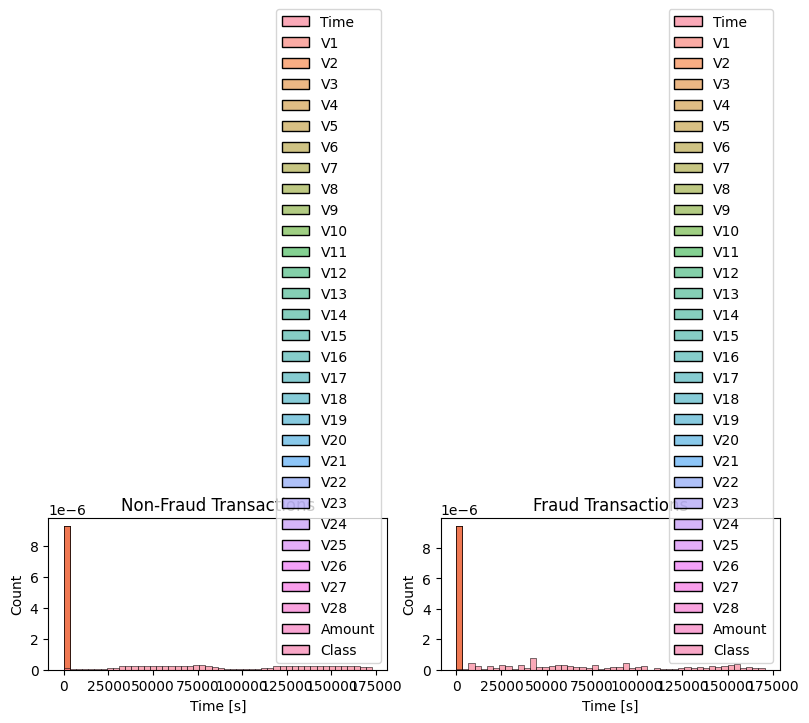

In [18]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1) # row,columns, position
sns.histplot(
    non_fraud_txn,
    bins=50,
    alpha = 0.6,
    stat ='density'
)
plt.title('Non-Fraud Transactions')
plt.xlabel('Time [s]')
plt.ylabel('Count')

plt.subplot(1,2,2) # row,column,position
sns.histplot(
    fraud_txn,
    bins=50,
    alpha = 0.6,
    stat ='density'
)
plt.title('Fraud Transactions')
plt.xlabel('Time [s]')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### **3.4 Correlation Heatmap**

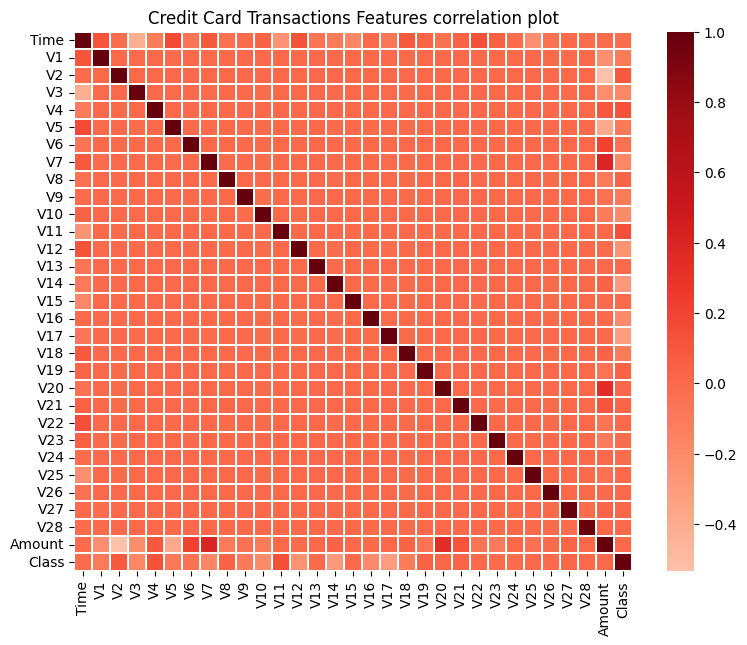

In [19]:
plt.figure(figsize=(9,7))
plt.title('Credit Card Transactions Features correlation plot')
corr = df.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=.1,
    cmap='Reds',
    center=0
)

plt.show();

**Amount vs. Class:** The correlation between the transaction amount and fraud (Class) is very weak (close to 0). This means the size of a transaction alone does not strongly indicate whether it is fraudulent.

**Time vs. Class:** The correlation between the transaction time and fraud is also very weak. This suggests that fraudulent transactions can occur at any time and are not concentrated at specific times in the dataset.

### **3.5 Top correlated features relation with Amount**

In [20]:
# top 5 features correlated the target (Class)
top_features = df.corr()['Class'].abs().sort_values(ascending=False)[1:6].index

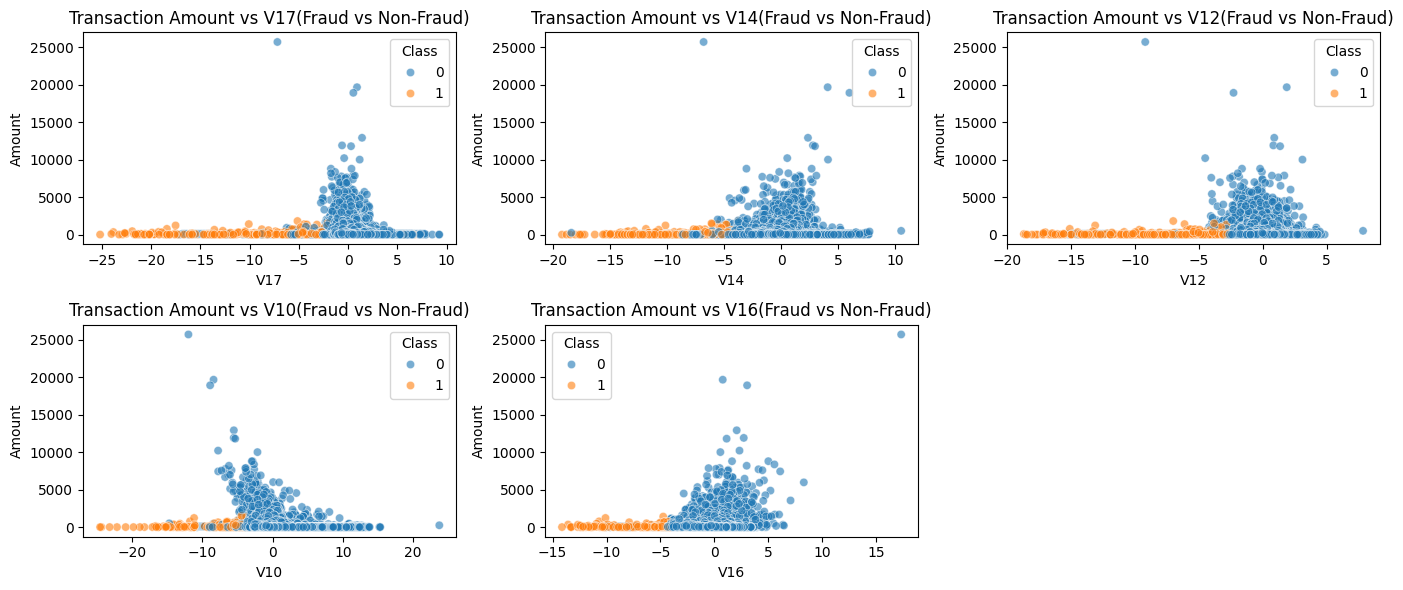

In [21]:
fig, axes = plt.subplots(2,3, figsize=(14,6))
axes = axes.flatten()

for i , features in enumerate(top_features):
  sns.scatterplot(
      x = features,
      y = 'Amount',
      hue='Class',
      data=df,
      alpha=0.6,
      ax=axes[i]
  )

  axes[i].set_title(f'Transaction Amount vs {features}(Fraud vs Non-Fraud)')

# Remove any unused subplot axes
for j in range(len(top_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The scatter plots show how transaction amount and the features V17, V14, V12, V10, and V16 are related. Fraud transactions (orange) usually happen with low amounts and negative feature values, forming small groups. These large negative values associated with low amount transactions are strong indicatores of fradulant transactions.

># **Key insights of Visulization:**


- Dataset is highly imbalanced, which makes fraud detection challenging.
- Fraud is rare and hidden amoung a vast number of normal transactions.
- High amounts alone don’t always indicate fraud, but extreme amounts are more likely to be fraudulent.
- Features : Class & Amount alone can not detect fraudulent transactions.

# **4. Splitting Features and Target**

In [22]:
# Features in X by droping target.
X = df.drop('Class', axis = 1)

# Target
y = df['Class']

# Train_Test_Split (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **5.  Phase 01 - Handling Imbalanced Data**

>Models are trained on the original imbalanced data using class weighting so they can handle real-world conditions.

###
Balanced the data using SMOTE to create more fraud samples and train models like Random Forest, AdaBoost, CatBoost, XGBoost, and LightGBM. Threshold tuning is applied to improve fraud detection.

## **5.1 SMOTE implementation**

In [23]:
# SMOTE implementation
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced =smote.fit_resample(X_train, y_train)

In [24]:
# Class distribution after resample
y_train_balanced.value_counts()

,count
Class,
0,226602
1,226602


## **5.2 Defining Tree based Models**

In [25]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

## **5.3 Train and Evaluate Models**

In [26]:
def evaluate_model(model, X_test, y_test, threshold=0.3):
  y_probs = model.predict_proba(X_test)[:,1]
  y_pred = (y_probs>= threshold).astype(int)

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_probs)

  print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC_AUC: {roc_auc:.4f}')

  print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

In [27]:
for name, model in models.items():
  print(f'Training {name}...')
  model.fit(X_train_balanced, y_train_balanced)
  print(f'Evaluation for {name} (threshold=0.3):')
  evaluate_model(model, X_test, y_test, threshold=0.3)
  print('')

Training RandomForest...
Evaluation for RandomForest (threshold=0.3):
Precision: 0.8333, Recall: 0.7895, F1-Score: 0.8108, ROC_AUC: 0.9609
Confusion Matrix:
 [[56636    15]
 [   20    75]]

Training AdaBoost...
Evaluation for AdaBoost (threshold=0.3):
Precision: 0.0017, Recall: 1.0000, F1-Score: 0.0034, ROC_AUC: 0.9516
Confusion Matrix:
 [[ 1047 55604]
 [    0    95]]

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[03:11:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Evaluation for XGBoost (threshold=0.3):
Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, ROC_AUC: 0.9660
Confusion Matrix:
 [[56632    19]
 [   19    76]]

Training CatBoost...
Evaluation for CatBoost (threshold=0.3):
Precision: 0.5065, Recall: 0.8211, F1-Score: 0.6265, ROC_AUC: 0.9594
Confusion Matrix:
 [[56575    76]
 [   17    78]]

Training LightGBM...
[LightGBM] [Info] Number of positive: 226602, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 453204, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Evaluation for LightGBM (threshold=0.3):
Precision: 0.5067, Recall: 0.8000, F1-Score: 0.6204, ROC_AUC: 0.9464
Confusion Matrix:
 [[56577    74]
 [   19    76]]



- **RandomForest** achieved high precision (0.83) and strong recall (0.79), giving an F1-score of 0.81 and ROC-AUC of 0.96.

- **AdaBoost** showed very poor precision (0.0017) despite perfect recall (1.0), resulting in an unusable F1-score of 0.003 and heavy false positives.

- **XGBoost** delivered balanced results with precision and recall both at 0.80, F1-score of 0.80, and the best ROC-AUC of 0.97.

- **CatBoost** provided high recall (0.82) but moderate precision (0.51), leading to an F1-score of 0.63 and ROC-AUC of 0.96.

- **LightGBM** performed similarly to CatBoost with recall of 0.80, precision of 0.51, F1-score of 0.62, and ROC-AUC of 0.95.

## **5.4 Threshold Tunning**

Finding the best probability threshold for the model instead of using the 0.3

**ROC Curve:** Uses Youden’s J statistic to maximize true positives while minimizing false positives.

**Precision-Recall Curve:** Finds the threshold with the highest F1-score, balancing precision and recall.

In [28]:
# # Function to plot ROC and Precision-Recall curves and find the best thresholds
def threshold_tunning(model, X_test, y_test, model_name="Model"):

  #predict_proba returns probabilities for both classes (0 and 1)
  #[:,1] selects the probability of the positive class (class 1)
  y_probs = model.predict_proba(X_test)[:,1]

  # ROC curve ------------------------------------------------------
  # false positive rate, true positive rate, threshold
  fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

  # Area under curve
  roc_auc_val = auc(fpr, tpr)

  # Best threshold using Youden's J statistics
  # J = tpr - fpr
  youden_index = tpr - fpr

  #best index of threshold by geting the highest index of youden's
  best_idx_roc = np.argmax(youden_index)

  # getting threshold value corresponding to Youden's index
  best_t_roc = roc_thresholds[best_idx_roc]


  # Precision, Recall Curve---------------------------------------
  precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
  f1 = 2*(precision[:-1]*recall[:-1])/(precision[:-1]+recall[:-1] + 1e-12)
  best_idx_pr = np.argmax(f1)
  best_t_pr = pr_thresholds[best_idx_pr]

  # Storing result
  result = {
      'Model': name,
      'ROC AUC': np.round(roc_auc_val,3),
      'Threshold (ROC)': np.round(best_t_roc,3),
      'Threshold (PR)': np.round(best_t_pr,3),
      'F1': np.round(max(f1),3)
  }

  return result

In [29]:
results = []
for name, model in models.items():
  result = threshold_tunning(model, X_test, y_test, name)
  results.append(result)

In [30]:
df_results = pd.DataFrame(results)
df_results

,Model,ROC AUC,Threshold (ROC),Threshold (PR),F1
0,RandomForest,0.961,0.050,0.530,0.825
1,AdaBoost,0.952,0.477,0.597,0.777
2,XGBoost,0.966,0.000,0.958,0.867
3,CatBoost,0.959,0.016,0.932,0.857
4,LightGBM,0.946,0.034,0.980,0.830


## **5.5 Model Evaluation basedo on best Threshold (PR)**

In [31]:
top_models = ['XGBoost', 'CatBoost']
selected_models = {}
for name in top_models:
  selected_models[name] = models[name]

In [32]:
# geting best PR threshold
best_pr_thresholds = {}
for name in top_models:
  best_pr_thresholds[name] = df_results.loc[df_results['Model']==name, 'Threshold (PR)'].values[0]

print('Best PR Thresholds:', best_pr_thresholds)

Best PR Thresholds: {'XGBoost': np.float64(0.9580000042915344), 'CatBoost': np.float64(0.932)}


In [33]:
# Defining Evaluation function for Best PR threshold
def evaluation_by_pr_threshold(model, X_test, y_test, threshold):
  y_probs = model.predict_proba(X_test)[:,1]
  y_pred = (y_probs>=threshold).astype(int)

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_probs)

  print(f"\nThreshold used: {threshold:.3f}")
  print('')
  print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, ROC_AUC: {roc_auc:.3f}")
  print('')
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

  return y_pred

In [34]:
# Evaluating top models - XGboost, Catboost
for name, model in selected_models.items():
  print(f'\nEvaluating {name} with PR-based threshold {best_pr_thresholds[name]:.3f}')
  y_pred = evaluation_by_pr_threshold(
      model, X_test, y_test, threshold=best_pr_thresholds[name]
  )


Evaluating XGBoost with PR-based threshold 0.958

Threshold used: 0.958

Precision: 0.962, Recall: 0.789, F1: 0.867, ROC_AUC: 0.966

Confusion Matrix:
 [[56648     3]
 [   20    75]]

Evaluating CatBoost with PR-based threshold 0.932

Threshold used: 0.932

Precision: 0.937, Recall: 0.779, F1: 0.851, ROC_AUC: 0.959

Confusion Matrix:
 [[56646     5]
 [   21    74]]


Both **XGBoost** and *CatBoost* improved dramatically after threshold tuning compared to earlier results.

**XGBoost** is slightly better — higher precision, recall, and F1, with fewer mistakes overall.

## **5.6 Fraud Decisioning with Risk Tiers**
>To make fraud detection more practical, cases are grouped into High, Medium, and Low Risk tiers based on fraud probability.
This tiered approach helps prioritize reviews, reduce false alarms, and align predictions with real-world decision-making.

- **High Risk (Reject / Flag)** → Fraud probability ≥ 0.7
- **Medium Risk (Review / Manual Check)** → 0.4 ≤ prob < 0.7
- **Low Risk (Approve)** → prob < 0.4

In [35]:
def fraud_tiers (model, X_test, y_test, model_name='Model'):

  #get probabilities for fraud transactions
  y_probs = model.predict_proba(X_test)[:,1]

  # categorize each probability into discrete risk bands
  decisions = pd.cut(
      y_probs,
      bins=[-np.inf, 0.4,0.7,np.inf],
      labels=['Low Risk', 'Medium Risk', 'High Risk']
  )

  # DataFrame to organize and analyze the model’s predictions
  df_decision = pd.DataFrame({
      'True_Label': y_test.values,  # Actual Class labels
      'Fraud_Probability': y_probs, # Predicted Fraud Probability
      'Decision': decisions         # Probability Threshold (Low,Medium,HIgh)
  })

  # Distribution of risk tiers
  tiers = df_decision.groupby(['Decision','True_Label']).size().unstack(fill_value=0)

  print(f'Risk Tiers Report: {model_name}---')
  print('\nDistribution of Predictions (rows=Risk Tier, cols=Actual):\n')
  print(tiers.to_string())

  tier_fraud_rate = df_decision.groupby('Decision', observed=False)['True_Label'].mean()
  print('\nFraud Rate in each tier (%):\n')
  print((tier_fraud_rate*100).round(2).to_string())
  print('')

  return df_decision

In [36]:
for name, model in selected_models.items():
  df_decision = fraud_tiers(model, X_test, y_test, model_name=name)

Risk Tiers Report: XGBoost---

Distribution of Predictions (rows=Risk Tier, cols=Actual):

True_Label       0   1
Decision              
Low Risk     56636  19
Medium Risk      9   0
High Risk        6  76

Fraud Rate in each tier (%):

Decision
Low Risk        0.03
Medium Risk     0.00
High Risk      92.68

Risk Tiers Report: CatBoost---

Distribution of Predictions (rows=Risk Tier, cols=Actual):

True_Label       0   1
Decision              
Low Risk     56602  17
Medium Risk     30   2
High Risk       19  76

Fraud Rate in each tier (%):

Decision
Low Risk        0.03
Medium Risk     6.25
High Risk      80.00



/tmp/ipython-input-2773945470.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2773945470.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



>**XGBoost** concentrated 92.7% of frauds in the High Risk tier, making it the most effective for practical decisioning.

>**CatBoost** achieved 80% fraud concentration in the High Risk tier but showed more mixed cases in Medium Risk compared to XGBoost.

# **6.  Phase 02 - Training Model by Class-Weight Balancing**

In [37]:
# Class Distribution
print('Class Distribution in Training Data', y_train.value_counts())

Class Distribution in Training Data Class
0    226602
1       378
Name: count, dtype: int64


In [39]:
# Scale_POS Weight
fraud, non_fraud = np.bincount(y_train)
scale = non_fraud / fraud
print(f'Scale_pos_weight for imbalanced data: {scale:.4f}')

Scale_pos_weight for imbalanced data: 0.0017


In [41]:
#Defining Models - RandomForest, XGBoost, CatBoost, LightGBM, AdaBoost
models_1 = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    'XGBoost'     : XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale),
    'CatBoost'    : CatBoostClassifier(verbose=0, random_state=42, scale_pos_weight=scale),
    'LightGBM'    : LGBMClassifier(random_state=42, scale_pos_weight=scale),
    'AdaBoost'    : AdaBoostClassifier(n_estimators=150, random_state=42)
}

In [40]:
# evaluation model
def evaluation_by_class_weight(model, X_test, y_test, threshold=0.3):
  y_probs = model.predict_proba(X_test)[:,1]
  y_pred = (y_probs >=threshold).astype(int)

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_probs)

  print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC_AUC: {roc_auc:.4f}')
  print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
  print('')

